
# Matthew Muller
1/19/23

Description:
- This script will train and evaluate a machine learning model using sklearn.

### Under the hood

In [1785]:
########################################
# Library Imports
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint
from scipy.stats import kruskal

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.svm import LinearSVC, SVC
from sklearn.decomposition import PCA, NMF
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.metrics import roc_curve, confusion_matrix

from joblib import load, dump

########################################
# Set/Append Working directory)

%cd ~/Ruggles Lab Dropbox/Matthew Muller/projects/platelet-activity

########################################
# Import Functions
from MattTools.plotting import plot_roc_curve, plot_confusion_matrix, plot_training_roc_curve_ci, plot_roc_curve_ci, plot_cross_validation_auroc
from MattTools.plotting import plot_scree, plot_training_probas
from MattTools.stats import bootstrap_auc_confidence
from MattTools import utils

# Hide warnings
utils.hide_warnings()
utils.set_random_seed()

/Users/muller/Ruggles Lab Dropbox/Matthew Muller/projects/platelet-activity
Setting random seed to 2735 for reproducibility.


### Load in Data

In [1786]:
path = 'data/clean/'
# genes = pd.read_table('data/genes_pace__nyu_mi_v_control.txt', header=None).values
# genes = "ZNF444"

# Naming convention for below:
# X_train = pd.read_csv('hyper_norm_rank/output/simple_ranking/pace_simpleRank.csv', index_col=0).T
X_train = pd.read_csv(path+'pace/features.csv')

y_train = pd.read_csv(path+'pace/labels.csv').to_numpy()[:,0]


# X_test = pd.read_csv('hyper_norm_rank/output/simple_ranking/duke_simpleRank.csv', index_col=0, header=0).T
X_test = pd.read_csv(path+'duke/features_group1.csv')

y_test = pd.read_csv(path+'duke/labels_group1.csv').to_numpy()[:,0]

X_test2 = pd.read_csv(path+'duke/features_group2.csv')

y_test2 = pd.read_csv(path+'duke/labels_group2.csv').to_numpy()[:,0]

# X_train = X_train[genes]
# X_test = X_test[genes]

X_test.shape, X_train.shape

((35, 451), (84, 451))

### Run Model

In [1787]:
# # # from sklearn.ensemble import VotingClassifier, RandomForestClassifier, ExtraTreesClassifier
# # from sklearn.ensemble import VotingClassifier, RandomForestClassifier, ExtraTreesClassifier

# # Find good rng seed
# auc = 0.5
# final_model = None
# for i in range(60000):
#     rng = randint(1e6, 2e6)
#     model = RandomForestClassifier(n_jobs=-1, random_state=rng, max_features='log2', class_weight='balanced', n_estimators=80).fit(X_train, y_train)
#     tmp = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
#     tmp2 = roc_auc_score(y_test2, model.predict_proba(X_test2)[:,1])
#     if (tmp > auc) and (tmp2 > auc*0.8):
#         print(f'New AUC is {tmp} with rng {rng}')
#         auc = tmp
#         model = final_model
#         # break

In [1788]:
#### Make model pipeline (if needed) and search for params
# The general idea here is fit each gene to a SVC and then add them into a voting classifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

# good RF random seeds:
seeds = [1148093, 1095286, 1665788, 97057, 152878, 4543, 277452, 295106, 191278, 701043, 81388, 951209, 1327001, 527903, 1148093, 1095286, 1665788, 97057, 152878, 4543, 277452, 295106, 191278, 701043, 81388, 951209, 1327001, 527903]
n = 28
# seeds = [randint(0,1000000) for x in range(n)]
pipe = Pipeline([
    ('scaler', StandardScaler()), 
    # ('pca', PCA()),
    # ('svc', SVC(probability=True, class_weight="balanced")),
    # ('knn', KNeighborsClassifier()),
    # ('logit', LogisticRegression(solver='saga', tol=1e3, max_iter=1000)),
    # ('percept', Perceptron(class_weight = 'balanced')),
    # ('rf', RandomForestClassifier(random_state=99779, max_features='log2', class_weight='balanced', n_estimators=10)), # 88783, 99779, 74302, 6746, 886045
    # ('extraTrees', ExtraTreesClassifier(class_weight='balanced', random_state=886045)), # [28982. 60930, 23877, 13486, 763030, 426674, 225914, 891248, 969902, 448175] # 38856, 508720, 573406, 859074, 741543
    # ('gbc', GradientBoostingClassifier(
    #     random_state=886045, 
    #     max_features='log2', 
    #     n_estimators=60
    #     ))
    # make a voting classifier made a bunch of RFs
    ('voting', VotingClassifier(
        estimators=[('rf'+str(i), RandomForestClassifier(random_state=seeds[i], max_features='log2', class_weight='balanced', n_estimators=80)) for i in range(n)] + \
        [('extraTrees'+str(i), ExtraTreesClassifier(class_weight='balanced', random_state=seeds[i])) for i in range(n) ] + \
        [('gbc'+str(i), GradientBoostingClassifier(random_state=seeds[i], max_features='log2', n_estimators=60)) for i in range(n) ] + \
        # [('knn'+str(i), KNeighborsClassifier(n_neighbors=5)) for i in range(n) ] + \
        # [('logit'+str(i), LogisticRegression(solver='saga', tol=1e3, max_iter=1000)) for i in range(n) ] + \
        # [('svc'+str(i), SVC(probability=True, class_weight="balanced", C=100)) for i in range(n) ] + \
        [('ada'+str(i), AdaBoostClassifier(random_state=seeds[i], learning_rate=1)) for i in range(n) ],
        voting='soft',
        # weights=[-i*0.1 for i in range(n)],
        n_jobs=-1,
        ))
    ])


parameters = {

    # 'pca__n_components':range(2,20),

    # Clf
    # 'svc__C':range(6,12),
    # 'svc__gamma':np.linspace(0.1, 1, 9),
    # 'svc__kernel':['rbf', 'linear', 'sigmoid'],

    # 'knn__n_neighbors':range(2,8),
    # 'knn__weights':['distance', 'uniform'],

    # 'logit__penalty':['l1', 'l2'],
    # # 'logit__l1_ratio':np.linspace(0,1,11),
    # 'logit__fit_intercept':[False],
    # 'logit__C':np.linspace(0.1,1,10),
    # 'logit__random_state':[randint(0,10000) for x in range(10)] + [7023],

    # 'percept__penalty':['l1', 'l2'],
    # 'percept__alpha':[0.001, 0.005],

    # 'rf__random_state':[randint(0,10000) for x in range(10)] + [66003, 9899, 4613, 57186, 90332],
    # 'rf__max_depth':range(6,15),

    # 'extraTrees__random_state':[randint(0,10000) for x in range(10)] + [38856, 508720, 573406, 859074, 741543, 173175],
    # 'extraTrees__max_features':["sqrt", "log2", None, 50, 100],
    # # 'extraTrees__max_depth':range(4,10,2),
    # 'extraTrees__min_samples_split':range(2,20,2),
    # 'extraTrees__class_weight':['balanced', None],
    # 'extraTrees__n_estimators':range(80,140, 4),
    # 'extraTrees__criterion':["gini", "entropy"]
    }

cv = GridSearchCV(
    pipe, parameters,
    n_jobs=-1,
    scoring="roc_auc",
    )

# Fit model
cv.fit(X_train, y_train)

model = cv.best_estimator_
print(cv.best_score_)
print(cv.best_params_)

0.8064102564102564
{}


In [1789]:
### If you are looking at a previous model
# model = load('models/jobs/extraTrees_trained_acc76.joblib')[-1]
# model.get_params()

### Evaludate Model

This function will be defunct in the future. Please use plot_cross_validation_auroc instead.


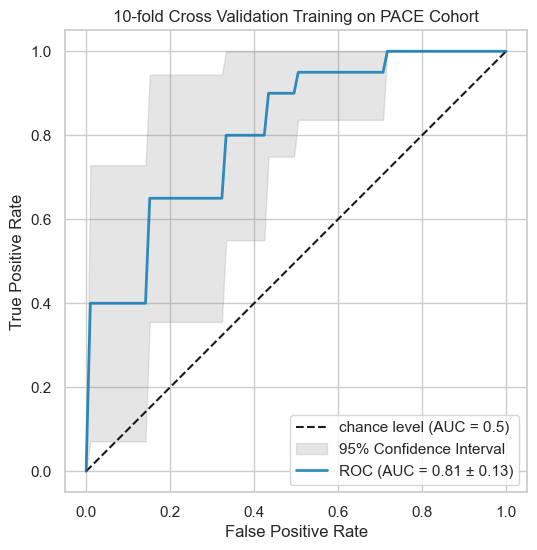

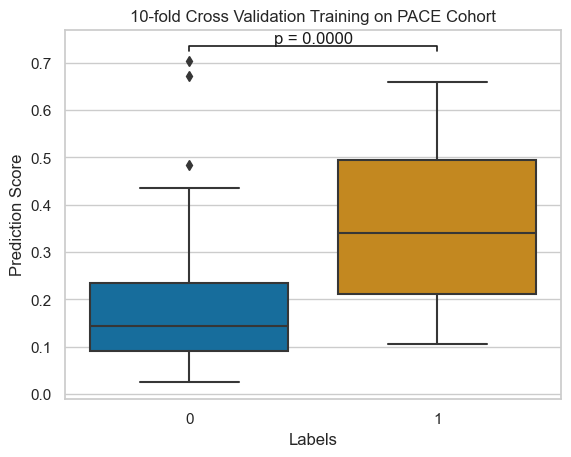

In [1799]:
from sklearn.model_selection import StratifiedKFold
# Training Stats

cv = StratifiedKFold(n_splits=10)

plot_cross_validation_auroc(
    model, X_train, y_train,
    title='10-fold Cross Validation Training on PACE Cohort',
    cv = cv,
    # save_path = '/Users/muller/Documents/RugglesLab/publications/pace_press/Pace Edits/training_roc.pdf'
    )

export = plot_training_probas(
    model, X_train, y_train,
    title='10-fold Cross Validation Training on PACE Cohort',
    cv = cv,
    # save_path = '/Users/muller/Documents/RugglesLab/publications/pace_press/Pace Edits/pace_boxplot.pdf'
)

              precision    recall  f1-score   support

           0       0.82      0.86      0.84        21
           1       0.77      0.71      0.74        14

    accuracy                           0.80        35
   macro avg       0.79      0.79      0.79        35
weighted avg       0.80      0.80      0.80        35



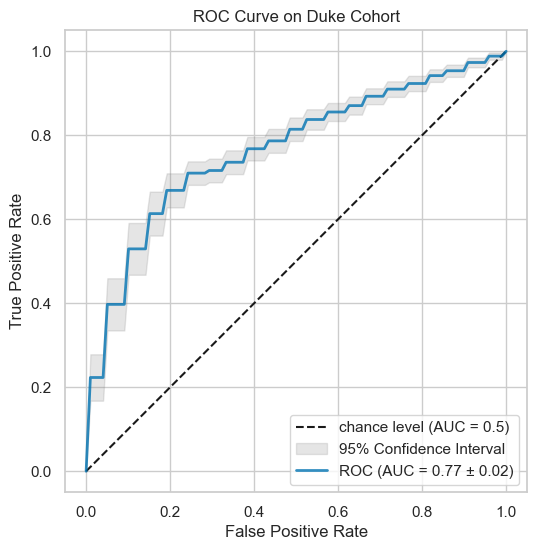

0.761904761904762


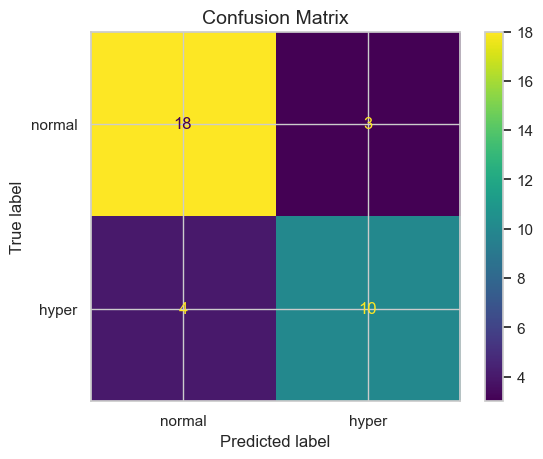

Logistic: PR AUC=0.672


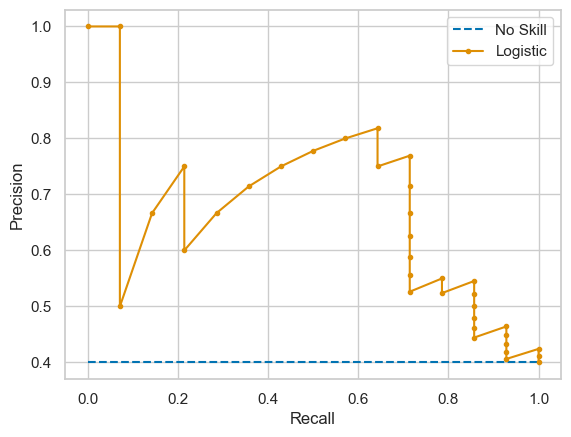

Text(0.5, 0.9, 'p=0.010')

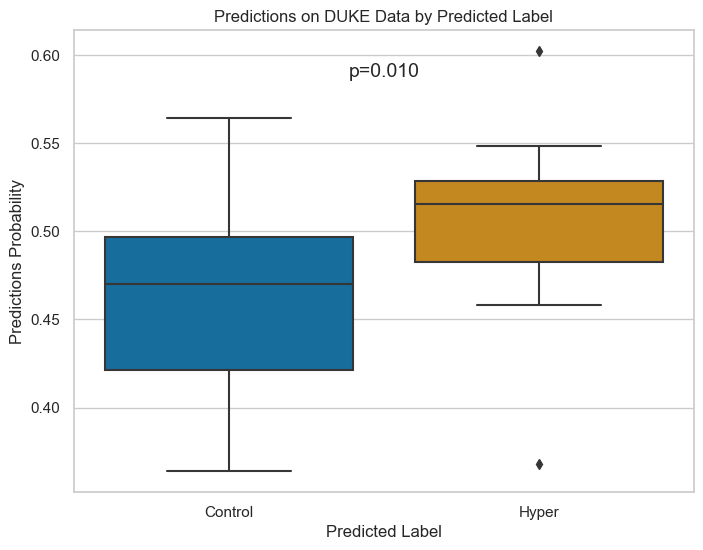

In [1795]:

#### Metrics
print(classification_report(y_test, model.predict(X_test)))

# plot_roc_curve(y_test, model.predict_proba(X_test)[:,1])

# plot_confusion_matrix(y_test, model.predict(X_test), labels = ['normal', 'hyper'])

plot_roc_curve_ci(
    model, X_test, y_test,
    title='ROC Curve on Duke Cohort',
    bootstraps=80,
    # save_path = '/Users/muller/Documents/RugglesLab/publications/pace_press/Pace Edits/duke_roc.pdf'
    )

# get the auc
print(roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))

# plot the confusion matrix
plot_confusion_matrix(y_test, model.predict(X_test), labels = ['normal', 'hyper'])

# plot the prc curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import auc

# predict probabilities
lr_probs = model.predict_proba(X_test)[:,1]
# calculate precision and recall for each threshold
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
# calculate scores
lr_auc = auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: PR AUC=%.3f' % (lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()



# plot the prediction scores
preds = model.predict_proba(X_test)[:,1]
label = model.predict(X_test)
scores = pd.DataFrame({'preds':preds, 'label':y_test})

# plot the scores as a boxplot of the z-scores by the labels
fig, ax = plt.subplots(figsize=(8,6))
sns.boxplot(data=scores, x='label', y='preds', ax=ax)
ax.set_ylabel('Predictions Probability')
ax.set_xlabel('Predicted Label')
ax.set_xticklabels(['Control', 'Hyper'])
ax.set_title('Predictions on DUKE Data by Predicted Label')
# get a p value
p = kruskal(scores.loc[scores['label']==0, 'preds'], scores.loc[scores['label']==1, 'preds'])[1]
# add significance
ax.text(0.5, 0.9, f'p={p:.3f}', transform=ax.transAxes, ha='center', fontsize=14)

# save the figure
fig.savefig('output/duke_preds.pdf', bbox_inches='tight')

In [1796]:
### Save Model

# dump(model, filename='models/jobs/press_01_model_voting_a_ton_of_trees.joblib')

['models/jobs/press_01_model_voting_a_ton_of_trees.joblib']

### Model Disease Correlations

In [1793]:
### Load in disease gene ratio data
sle_ratios = pd.read_csv('data/clean/model_validation/sle/sle_features_labels.csv', index_col=0)
male_ratios = pd.read_csv('data/clean/model_validation/male/male_features_labels.csv', index_col=0)
mace_ratios = pd.read_csv('data/clean/model_validation/mace/mace_features_labels.csv', index_col=0)
covid_ratios = pd.read_csv('data/clean/model_validation/covid/covid_features_labels.csv', index_col=0)
pad_ratios = pd.read_csv('data/clean/model_validation/pad/pad_features_labels.csv', index_col=0)
harp_ratios = pd.read_csv('data/clean/model_validation/harp/harp_features_labels.csv', index_col=0)


### Load in disease gene ratio data
# sle_ratios = pd.read_csv('data/clean/gene_ratios/disease_ratios/sle_gene_ratios_filtered_pace_60', index_col=0)
# male_ratios = pd.read_csv('data/clean/gene_ratios/disease_ratios/male_gene_ratios_filtered_pace_60', index_col=0)
# mace_ratios = pd.read_csv('data/clean/gene_ratios/disease_ratios/mace_gene_ratios_filtered_pace_60', index_col=0)
# covid_ratios = pd.read_csv('data/clean/gene_ratios/disease_ratios/covid_gene_ratios_filtered_pace_60', index_col=0)
# pad_ratios = pd.read_csv('data/clean/gene_ratios/disease_ratios/pad_gene_ratios_filtered_pace_60', index_col=0)
# harp_ratios = pd.read_csv('data/clean/gene_ratios/disease_ratios/harp_gene_ratios_filtered_pace_60', index_col=0)

disease_ratios = {'sle':sle_ratios, 'male':male_ratios, 'mace':mace_ratios, 
                  'covid':covid_ratios, 'pad':pad_ratios, 'harp':harp_ratios}

male_ratios

,AAMDC,AASDHPPT,ABCB7,ABHD17B,AC002091.1,AC004053.1,AC005229.4,AC005332.6,AC006213.2,AC006378.2,...,ZHX1-C8orf76,ZNF185,ZNF33A,ZNF44,ZNF451,ZNF517,ZNF706,ZNF800,ZNF804A,cohort
PACE_001,52.525035,226.514215,0.000000,85.353182,9.848444,1730.043349,9.848444,405.427616,101.767256,8.207037,...,0.000000,33901.627452,1178.530479,9.848444,774.744270,54.166443,1088.253074,160.857921,0.000000,1
PACE_003,41.625585,322.774667,88.542559,121.701923,18.343478,927.051174,14.110368,937.281190,88.542559,22.576589,...,3.527592,28211.916896,905.885622,225.413128,564.414718,24.340385,900.241474,332.299165,14.110368,0
PACE_004,59.485647,71.202517,78.412899,2.703893,14.420763,550.692886,8.111679,1277.138820,91.932364,23.433740,...,11.716870,26524.289587,413.695638,18.025954,263.178924,0.000000,595.757770,122.576485,44.163587,1
PACE_005,53.805840,138.460361,33.000915,81.784877,2.869645,185.809501,4.304467,1017.289081,41.609850,4.304467,...,6.456701,36238.591914,489.274438,79.632643,281.942601,38.740205,401.032860,126.981782,2.869645,1
PACE_006,32.566297,264.460795,24.705467,81.415744,12.914221,402.025328,3.930415,637.850240,21.898028,17.406125,...,3.368927,25653.820096,654.694877,211.119446,761.377576,19.090588,547.450690,326.224463,2.807439,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PACE_285,84.103428,91.112047,0.000000,1.752155,0.000000,413.508523,19.273702,3527.087529,12.265083,47.308178,...,42.051714,22802.542031,532.655047,21.025857,310.131392,17.521548,478.338249,71.838345,0.000000,0
PACE_289,51.254936,156.779803,46.732441,24.119970,4.522494,901.483867,15.074981,1028.113708,76.882403,25.627468,...,9.044989,47891.707295,767.316535,36.179955,438.681949,36.179955,413.054481,24.119970,10.552487,0
PACE_293,64.681241,196.855951,1.406114,15.467253,8.436684,828.201108,26.716165,1390.646683,104.052431,11.248911,...,7.030570,46967.017686,624.314588,26.716165,482.297080,8.436684,569.476144,67.493469,0.000000,0
PACE_295,33.123986,85.425016,0.000000,10.460206,5.230103,523.010305,3.486735,1938.624864,27.893883,0.000000,...,24.407148,51132.974151,470.709274,33.123986,198.743916,3.486735,367.850581,26.150515,0.000000,0


In [1794]:
### Prediction Results

for key in disease_ratios.keys():
    print(f'##################################### Current Disease: {key.upper()} #####################################')
    
    features = disease_ratios[key].drop('cohort', axis=1)
    labels = disease_ratios[key]['cohort']

    print(classification_report(labels, model.predict(features)))

    plot_roc_curve(labels, model.predict_proba(features)[:,1])


        # Predict and graph things
    preds = model.predict(features)
    conf_matrx = confusion_matrix(labels, preds)
    auc_score = roc_auc_score(labels, model.predict_proba(features)[:,1])


    sns.heatmap(conf_matrx, xticklabels=["Normal", "Hyper"], yticklabels=["Healthy", key],
                cmap="Blues", annot=True, fmt='g').set_title(f"{key} Platelet Activity Correlations \nAUC: {auc_score:.2f}")
    plt.show()


    # Weird results here, so I figure making a histogram of the model is helpful
    sns.set_theme(style="whitegrid", palette="colorblind")
    df = pd.DataFrame({'preds' : model.predict_proba(features)[:,1]})
    df['labels'] = labels.values
    df['labels'] = df['labels'].map({0:"Normal", 1:key})
    sns.boxplot(
        df, x='labels', y='preds', 
        order=["Normal", key], boxprops={'alpha': 0.75}
        ).set(ylabel="Prediction Value", xlabel=None)
    sns.stripplot(
        df, x='labels', y='preds',
        color = 'black', alpha = 0.75,
        order=["Normal", key]
        ).set(ylabel="Prediction Value", xlabel=None)

    # Significance Testing (kruskal-wallis for nonparametric analysis)    
    kruskal_wallis = kruskal(df.loc[df['labels'] == "Normal"]['preds'], df.loc[df['labels'] == key]['preds'])
    if kruskal_wallis[1] < 0.05:
        # statistical annotation
        x1, x2 = 0, 1
        y, h = df['preds'].max()+0.01, 0.01
        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.2, c='k')
        plt.text((x1+x2)*.5, y+h, f"p = {kruskal_wallis[1]:.4f}",
                 ha='center', va='bottom', color='k')

    plt.show()

##################################### Current Disease: SLE #####################################


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- AAMDC
- ABCB7
- AC002091.1
- AC005229.4
- AC005332.6
- ...
Feature names seen at fit time, yet now missing:
- ABHD17A
- ABHD18
- AC104248.1
- AC120114.1
- AC131971.1
- ...
